# Time Series Forecasting

Using the acres burned dataframe, we will construct a forecast that will predict acres burned over the next 10 years. This will then be used to create predictions for wildfire suppression costs and insurance losses.

In [1]:
# Check conda environment - should be sktime
!conda env list

# conda environments:
#
base                     /Users/claireph/opt/anaconda3
sktime                *  /Users/claireph/opt/anaconda3/envs/sktime



In [47]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sktime.forecasting.naive import NaiveForecaster
from sktime.forecasting.arima import AutoARIMA
from sktime.forecasting.ets import AutoETS
from sktime.utils.plotting.forecasting import plot_ys
from sktime.forecasting.model_selection import temporal_train_test_split

import pmdarima as pmd
from pmdarima.utils import tsdisplay


from sklearn.metrics import mean_absolute_error

import matplotlib.pyplot as plt
plt.style.use('ggplot')

import warnings
warnings.filterwarnings("ignore")

In [3]:
acres_df = pd.read_csv('./claire_data/acres_clean.csv', index_col='Unnamed: 0')

In [4]:
acres_df.tail()

,acres_burned
2016,5.402921e+05
2017,1.415352e+06
2018,1.584802e+06
2019,2.753229e+05
2020,4.149345e+06


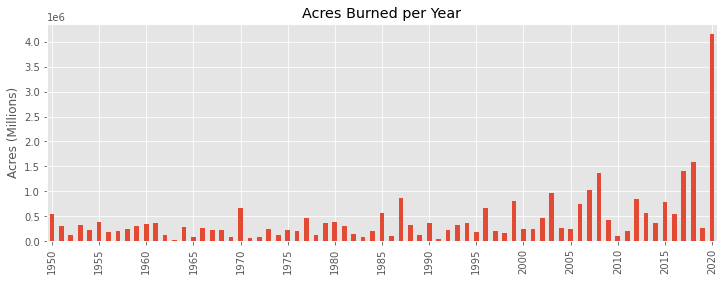

In [116]:
# Code source: https://stackoverflow.com/questions/12608788/changing-the-tick-frequency-on-x-or-y-axis-in-matplotlib/12608937
acres_df['acres_burned'].plot(kind='bar', figsize=(12,4))
plt.xticks(np.arange(0, 71, 5.0))
plt.title('Acres Burned per Year')
plt.ylabel('Acres (Millions)');

In [6]:
y = acres_df['acres_burned'].reset_index(drop=True)
y

0     5.375387e+05
1     3.057212e+05
2     1.323705e+05
3     3.338548e+05
4     2.187340e+05
          ...     
66    5.402921e+05
67    1.415352e+06
68    1.584802e+06
69    2.753229e+05
70    4.149345e+06
Name: acres_burned, Length: 71, dtype: float64

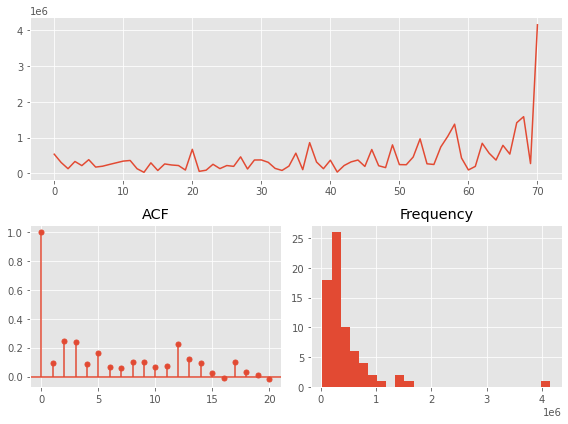

In [48]:
tsdisplay(y, lag_max=20);

In [54]:
y_train, y_test = temporal_train_test_split(y, test_size=15)

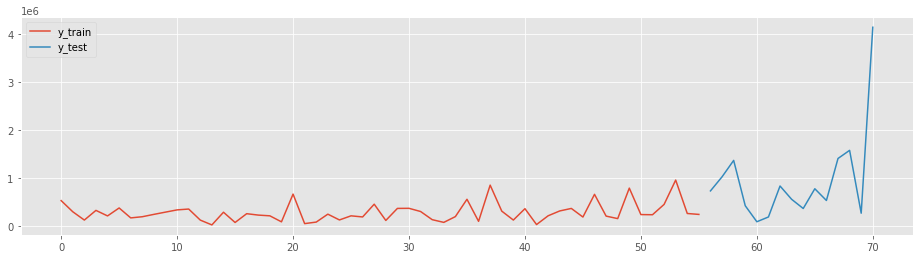

In [55]:
plot_ys(y_train, y_test, labels=['y_train', 'y_test']);

In [56]:
naive_model_mean = NaiveForecaster(strategy='mean')
naive_model_mean.fit(y_train)
y_preds_mean = naive_model_mean.predict(list(range(1, len(y_test)+1)))
mean_absolute_error(y_test, y_preds_mean)

708611.8512042619

In [105]:
naive_model_season = NaiveForecaster(strategy='last', sp=5)
naive_model_season.fit(y_train)
y_preds_season = naive_model_season.predict(list(range(1, len(y_test)+1)))
mean_absolute_error(y_test, y_preds_season)

602886.7150199999

In [102]:
sarima_model = AutoARIMA(sp=10, suppress_warnings=True)
sarima_model.fit(y_train)
y_preds_sarima = sarima_model.predict(list(range(1, len(y_test)+1)))
mean_absolute_error(y_test, y_preds_sarima)

708611.8512042619

In [103]:
hw_model = AutoETS(auto=True, sp=10)
hw_model.fit(y_train.astype('float'))
y_preds_hw = hw_model.predict(list(range(1, len(y_test)+1)))
mean_absolute_error(y_test, y_preds_hw)

595140.5962298686

In [73]:
aa_model = pmd.auto_arima(y_train, suppress_warnings=True, trace=True, m=10)
y_preds_aa = aa_model.predict(y_test.shape[0])
mean_absolute_error(y_test, y_preds_aa)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[10] intercept   : AIC=1536.651, Time=0.39 sec
 ARIMA(0,0,0)(0,0,0)[10] intercept   : AIC=1529.036, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[10] intercept   : AIC=1531.921, Time=0.04 sec
 ARIMA(0,0,1)(0,0,1)[10] intercept   : AIC=1531.950, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[10]             : AIC=1591.837, Time=0.00 sec
 ARIMA(0,0,0)(1,0,0)[10] intercept   : AIC=1531.034, Time=0.02 sec
 ARIMA(0,0,0)(0,0,1)[10] intercept   : AIC=1531.030, Time=0.02 sec
 ARIMA(0,0,0)(1,0,1)[10] intercept   : AIC=1533.030, Time=0.13 sec
 ARIMA(1,0,0)(0,0,0)[10] intercept   : AIC=1530.082, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[10] intercept   : AIC=1530.175, Time=0.01 sec
 ARIMA(1,0,1)(0,0,0)[10] intercept   : AIC=1532.074, Time=0.02 sec

Best model:  ARIMA(0,0,0)(0,0,0)[10] intercept
Total fit time: 0.696 seconds


708611.8512042619

In [74]:
y_preds_aa

array([292820.85081179, 292820.85081179, 292820.85081179, 292820.85081179,
       292820.85081179, 292820.85081179, 292820.85081179, 292820.85081179,
       292820.85081179, 292820.85081179, 292820.85081179, 292820.85081179,
       292820.85081179, 292820.85081179, 292820.85081179])

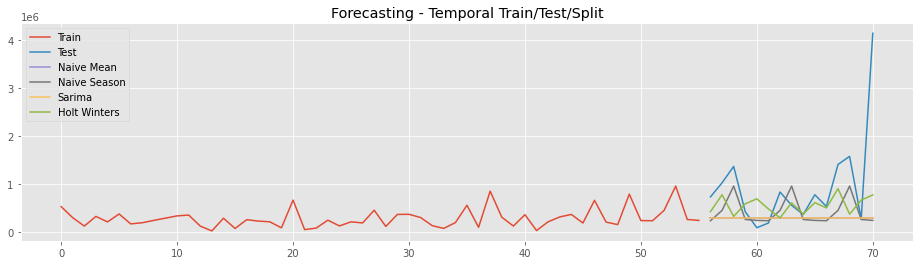

In [106]:
plot_ys(y_train, y_test, y_preds_mean, y_preds_season, y_preds_sarima, y_preds_hw,
        labels=['Train', 'Test', 'Naive Mean', 'Naive Season', 'Sarima', 'Holt Winters']);
plt.title('Forecasting - Temporal Train/Test/Split');

In [76]:
naive_model_season_ext = NaiveForecaster(strategy='last', sp=10)
naive_model_season_ext.fit(y)
y_preds_season_ext = naive_model_season_ext.predict(list(range(1, 11)))

In [84]:
hw_model = AutoETS(auto=True, sp=10)
hw_model.fit(y.astype('float'))
y_preds_hw_ext = hw_model.predict(list(range(1, 11)))

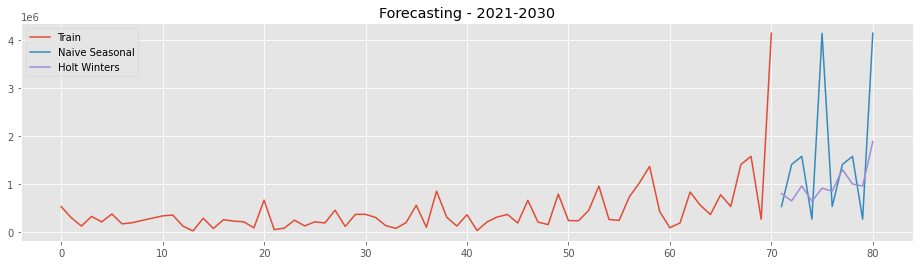

In [107]:
plot_ys(y, y_preds_season_ext, y_preds_hw_ext, labels = ['Train', 'Naive Seasonal', 'Holt Winters']);
plt.title('Forecasting - 2021-2030');

In [78]:
predictions_df = pd.DataFrame(
    {'year': list(range(2021, 2031)),
     'pred_acres': y_preds_season_ext})

In [79]:
predictions_df['pred_cost'] = predictions_df['pred_acres'] * 3072.86

In [80]:
predictions_df['pred_structures_destroyed'] = predictions_df['pred_acres'] * 0.0047

In [81]:
# Source: https://pbpython.com/styling-pandas.html
format_dict = {'pred_acres': '{0:,.0f}', 'pred_cost':'${0:,.0f}', 'pred_structures_destroyed': '{0:,.2f}'}
predictions_df.style.format(format_dict).hide_index()

year,pred_acres,pred_cost,pred_structures_destroyed
2021,"540,292","$1,660,242,038","2,539.37"
2022,"1,415,352","$4,349,177,416","6,652.15"
2023,"1,584,802","$4,869,876,147","7,448.57"
2024,"275,323","$846,028,819","1,294.02"
2025,"4,149,345","$12,750,356,277","19,501.92"
2026,"540,292","$1,660,242,038","2,539.37"
2027,"1,415,352","$4,349,177,416","6,652.15"
2028,"1,584,802","$4,869,876,147","7,448.57"
2029,"275,323","$846,028,819","1,294.02"
2030,"4,149,345","$12,750,356,277","19,501.92"


In [82]:
predictions_df['pred_cost'].sum()

48951361393.2442

In [87]:
hw_predictions_df = pd.DataFrame(
    {'year': list(range(2021, 2031)),
     'pred_acres': y_preds_hw_ext})

In [88]:
hw_predictions_df['pred_cost'] = hw_predictions_df['pred_acres'] * 3072.86

In [89]:
hw_predictions_df['pred_structures_destroyed'] = hw_predictions_df['pred_acres'] * 0.0047

In [92]:
format_dict = {'pred_acres': '{0:,.0f}', 'pred_cost':'${0:,.0f}', 'pred_structures_destroyed': '{0:,.2f}'}
hw_predictions_df.style.format(format_dict).hide_index()

year,pred_acres,pred_cost,pred_structures_destroyed
2021,"808,901","$2,485,638,288","3,801.83"
2022,"656,504","$2,017,344,478","3,085.57"
2023,"968,346","$2,975,592,515","4,551.23"
2024,"650,549","$1,999,044,645","3,057.58"
2025,"921,094","$2,830,393,713","4,329.14"
2026,"860,562","$2,644,387,354","4,044.64"
2027,"1,312,546","$4,033,270,147","6,168.97"
2028,"1,009,987","$3,103,548,463","4,746.94"
2029,"965,447","$2,966,684,575","4,537.60"
2030,"1,891,605","$5,812,638,846","8,890.55"


In [93]:
hw_predictions_df['pred_cost'].sum()

30868543021.961823